In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set_style("darkgrid")  

from termcolor import colored as cl 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LeakyReLU

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, min_delta = 0.00000000001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [6]:
def read_data(filename, sheetname):
    df = pd.read_excel("data.xlsx", sheet_name = sheetname)[:-1]
    df['Date'] = pd.to_datetime(df['Date'])
#     df['volume'] = (df['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) *\
#           df['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).\
#           fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
    df.set_index('Date', inplace = True)
    df = df[['Price']]
    df.columns = ['price']
    df = df.sort_index()
    df = df.rolling(7).mean().dropna()
    
    return df


def Lookback_data(df, lookback):
    data_raw = df.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback + 1])
    data = np.array(data)
    
    X = data [:, :-1, :].reshape(len(data), 5)
    y = data[:, -1, 0].reshape(-1,1)
    
    
    df_featured = pd.DataFrame(X)
    df_featured['y'] = y
    df_featured.set_index(df.index[lookback:], inplace = True)
    return df_featured


def split_dataset(df, train_ratio = 0.7, validation_ratio = 0.1):
    assert train_ratio + validation_ratio <= 0.8, "Train + validation ratio should be less than or equal to 0.8"
    

    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * validation_ratio)
    test_size = len(df) - train_size - val_size
    train, val,  test = df.iloc[0:train_size,:], df.iloc[train_size: train_size + val_size,:]  ,\
        df.iloc[train_size+val_size:len(df),:]
        
    return train, val, test


def scaling (train, val, test):

    scaler = MinMaxScaler(feature_range=(0, 1))

    train_scaled = pd.DataFrame(scaler.fit_transform(train[train.columns]))
    val_scaled = pd.DataFrame(scaler.transform(val[val.columns]))
    test_scaled = pd.DataFrame(scaler.transform(test[test.columns]))
    train_scaled.columns = ['day1', 'day2', 'day3', 'day4', 'day5', 'y']
    val_scaled.columns = ['day1', 'day2', 'day3', 'day4', 'day5', 'y']
    test_scaled.columns = ['day1', 'day2', 'day3', 'day4', 'day5', 'y']
    
    return train_scaled, val_scaled, test_scaled


def seperate_feature_target(train, val, test):
    X_train = train.drop('y', axis=1).values
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = train['y'].values


    X_val = val.drop('y', axis=1).values
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    y_val = val['y'].values

    X_test = test.drop('y', axis=1).values
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = test['y'].values
    
    return X_train, y_train, X_val, y_val, X_test, y_test


def NN_model(layer1_lstm=100, layer2_lstm=100, layer3_lstm=100):
    model = Sequential()
    model.add(LSTM(layer1_lstm, return_sequences= True, activation='relu', input_shape=(5, 1)))
    model.add(LSTM(layer2_lstm, return_sequences=True, activation='relu'))
    model.add(LSTM(layer3_lstm))
    model.add(Dense(1))
    model.summary()
    return model

def plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict):

    fig = plt.figure(figsize = (20,8))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 3, 1)
    ax = sns.lineplot(x = np.arange(0,len(y_train)), y = y_train, label="Data", color='royalblue')
    ax = sns.lineplot(x = np.arange(0,len(y_train)), y = y_train_predict.reshape(-1), label="Training Prediction (LSTM)", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)


    plt.subplot(1, 3, 2)
    ax = sns.lineplot(x = np.arange(0,len(y_val)), y = y_val, label="Data", color='royalblue')
    ax = sns.lineplot(x = np.arange(0,len(y_val)), y = y_val_predict.reshape(-1), label="Validation Data Prediction (LSTM)", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)

    plt.subplot(1, 3, 3)
    ax = sns.lineplot(x = np.arange(0,len(y_test)), y = y_test, label="Data", color='royalblue')
    ax = sns.lineplot(x = np.arange(0,len(y_test)), y = y_test_predict.reshape(-1), label="Test Data Prediction (LSTM)", color='tomato')
    ax.set_title('Stock price', size = 14, fontweight='bold')
    ax.set_xlabel("Days", size = 14)
    ax.set_ylabel("Cost (USD)", size = 14)
    ax.set_xticklabels('', size=10)
    plt.show()
    
def run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks):
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data=(X_val, y_val), callbacks=callbacks)
    
    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_val)
    y_test_predict = model.predict(X_test)
    
    
    plot_predictions(y_train, y_val, y_test, y_train_predict, y_val_predict, y_test_predict)
    
    
    predictions = np.concatenate([y_train_predict, y_val_predict, y_test_predict])

    
    return predictions



    
    
def scaler_inverse(train_array, predictions):
    scaler = MinMaxScaler(feature_range = (0,1))
    c = train_array.reshape(-1,1)
    scaler.fit(c)
    prediction_inverse = scaler.inverse_transform(predictions)
    return prediction_inverse

def get_bollinger_bands(df, days):
    df['rolling_avg'] = df['predicted'].rolling(days).mean()
    df['rolling_std'] = df['predicted'].rolling(days).std()
    df['Upper Band']  = df['rolling_avg'] + (df['rolling_std'] * 2)
    df['Lower Band']  = df['rolling_avg'] - (df['rolling_std'] * 2)
    df = df.dropna()
    return df




    
def plot_bollinger(df):
    
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)

    # Get index values for the X axis for facebook DataFrame
    x_axis = df.index.get_level_values(0)
    ax.fill_between(x_axis, df['Upper Band'], df['Lower Band'], color='grey')

    # Plot Adjust Closing Price and Moving Averages
    ax.plot(x_axis, df['predicted'], color='blue', lw=2)
    ax.plot(x_axis, df['rolling_avg'], color='black', lw=2)

    # Set Title & Show the Image
    ax.set_title('20 Day Bollinger Band')
    ax.set_xlabel('Date (Year/Month)')
    ax.set_ylabel('Price(USD)')

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1,len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal


def plot_bb_strategy(df, buy_price, sell_price):
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = (20, 10)
    df['predicted'].plot(label = 'PREDICTED PRICES', alpha = 0.3)
    df['Upper Band'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
    df['rolling_avg'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
    df['Lower Band'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
    plt.scatter(df.index[1:], buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
    plt.scatter(df.index[1:], sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
    plt.title('BB STRATEGY TRADING SIGNALS')
    plt.legend(loc = 'upper left')
    plt.show()
    
def capital_gain_predicted_prices(df1, df2):
    # Define the total capital gain as the final value minus the initial value divided by the initial value
    actual_returns = (df1.iloc[-1] - df1.iloc[0])/df1.iloc[0]
    # Predicted returns 
    predicted_returns = (df2.iloc[-1] - df2.iloc[0])/df2.iloc[0]
    # Show the value as percentage
    actual_returns = round(actual_returns*100,2)
    predicted_returns = round(predicted_returns*100, 2)
    print('The actual returns had a value of {}% and the predicted returns had a value {}%'.format(actual_returns, 
                                                                                                predicted_returns))
    
    
def get_bollinger_df(actuals, predictions, days):
    pred_df = pd.DataFrame(predictions)
    pred_df.columns = ['predicted']
    pred_df['actuals'] = actuals
    pred_df = get_bollinger_bands(pred_df, days)
    
    pred_df = pred_df.reset_index(drop=True)
    
#     display(pred_df.head())
    buy_price, sell_price, bb_signal = \
    implement_bb_strategy(pred_df['predicted'], pred_df['Lower Band'], pred_df['Upper Band'])
    
    plot_bb_strategy(pred_df, buy_price, sell_price )
    
    
    pred_df = pred_df.iloc[1:].reset_index(drop=True)
    pred_df['bb_signal'] = bb_signal
    
    
    capital_gain_predicted_prices(df1 = pred_df['actuals'], df2 = pred_df['predicted'])
    
    return pred_df



    

## S_Stock

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 100)            80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 5s 231ms/step - loss: 0.2108 - val_loss: 0.6861

Epoch 00001: val_loss improved from inf to 0.68608, saving model to model.h5
Epoch 2/100
7/7 [==============================] - 0s 17ms/step - loss:

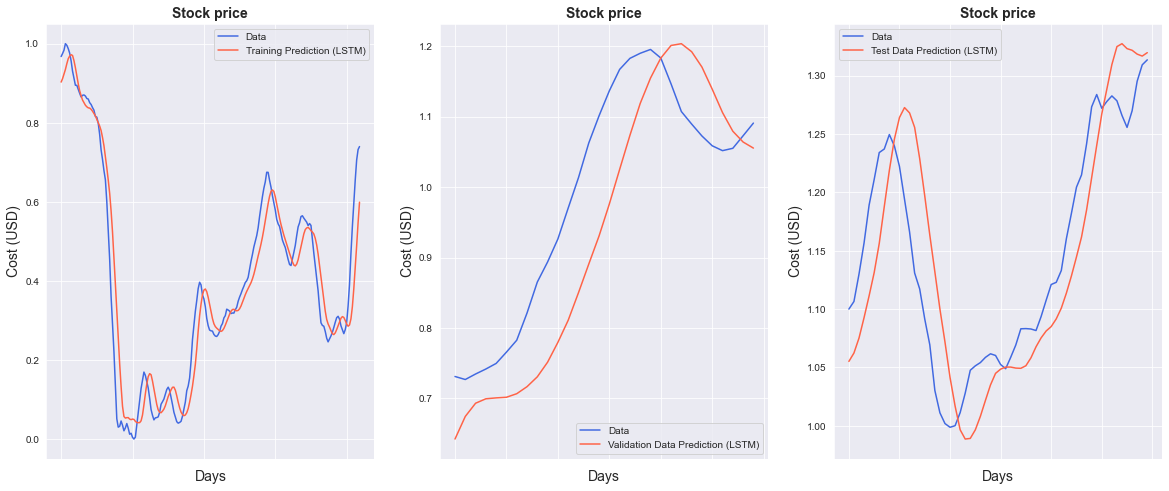

In [7]:
s_stock = read_data("data.xlsx", 0)

s_stock_features = Lookback_data(s_stock, 5)

s_train, s_val, s_test = split_dataset(s_stock_features)

s_train_scaled, s_val_scaled, s_test_scaled = scaling(s_train, s_val, s_test)

X_train, y_train, X_val, y_val, X_test, y_test = seperate_feature_target(s_train_scaled, s_val_scaled, s_test_scaled)

model = NN_model()

s_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)




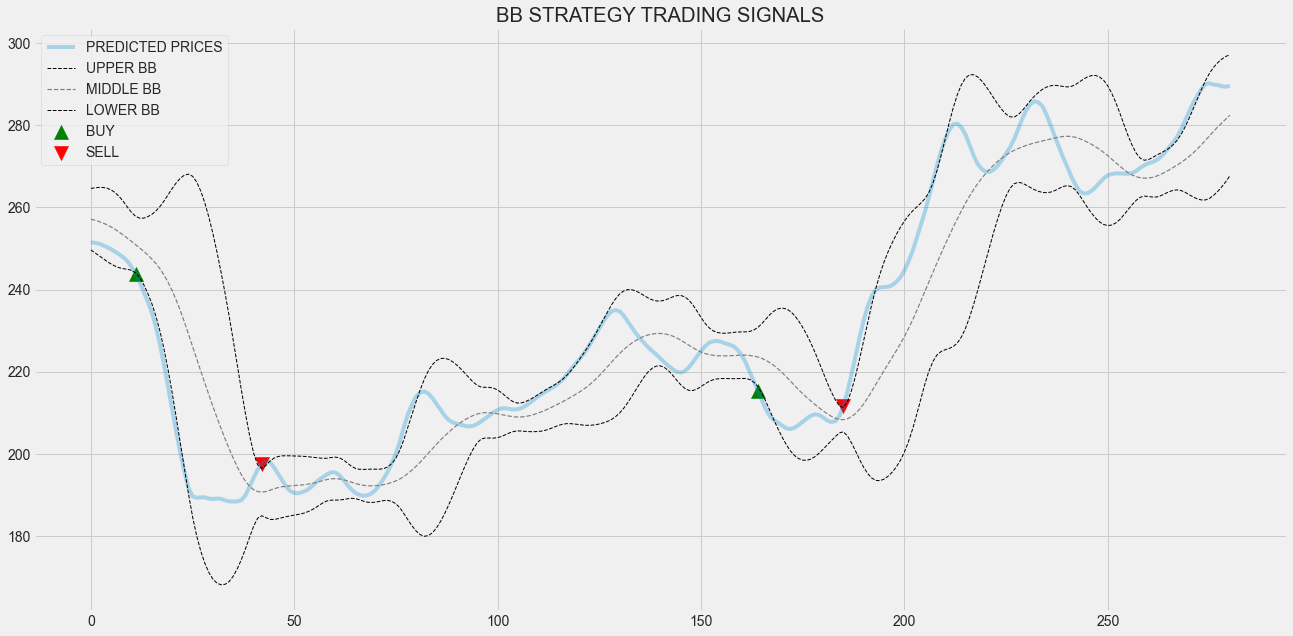

The actual returns had a value of 14.51% and the predicted returns had a value 15.19%


In [8]:
s_pred_prices = scaler_inverse(train_array = s_train['y'].values, predictions = s_predictions)
s_actuals = s_stock_features['y'].values


s_bollinger_df = get_bollinger_df(s_actuals, s_pred_prices, 20 )

## KCHOL

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 200)            161600    
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 200)            320800    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 4s 125ms/step - loss: 0.1771 - val_loss: 0.1160

Epoch 00001: val_loss did not improve from 0.01043
Epoch 2/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0483 - val_loss: 0.03

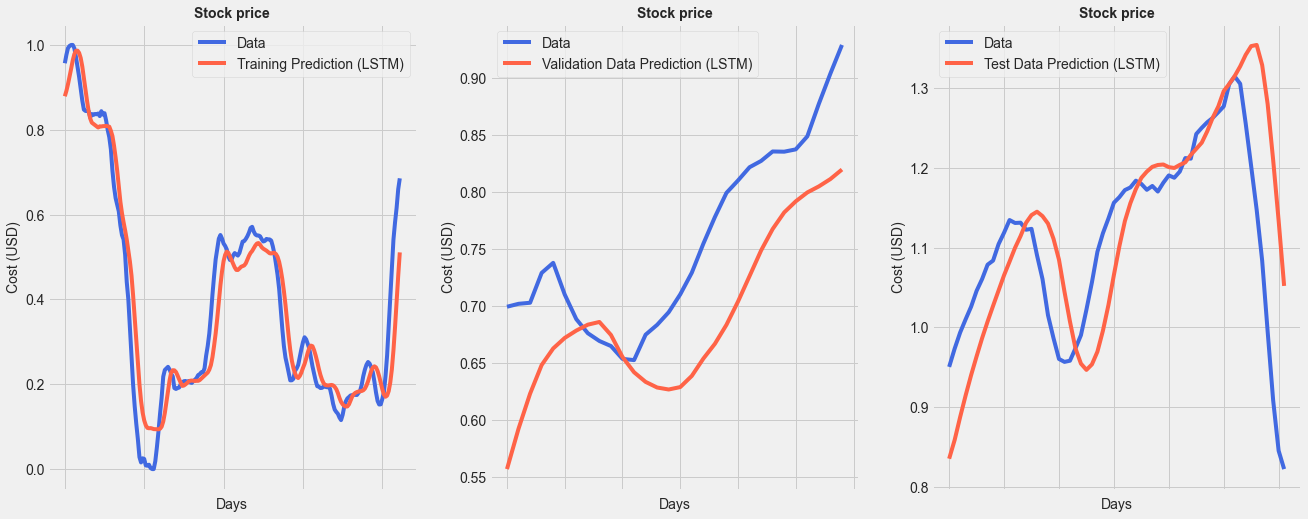

In [9]:
k_stock = read_data("data.xlsx", 1)

k_stock_features = Lookback_data(k_stock, 5)

k_train, k_val, k_test = split_dataset(k_stock_features)

k_train_scaled, k_val_scaled, k_test_scaled = scaling(k_train, k_val, k_test)

X_train, y_train, X_val, y_val, X_test, y_test = seperate_feature_target(k_train_scaled, k_val_scaled, k_test_scaled)

model = NN_model(200,200,200)

k_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

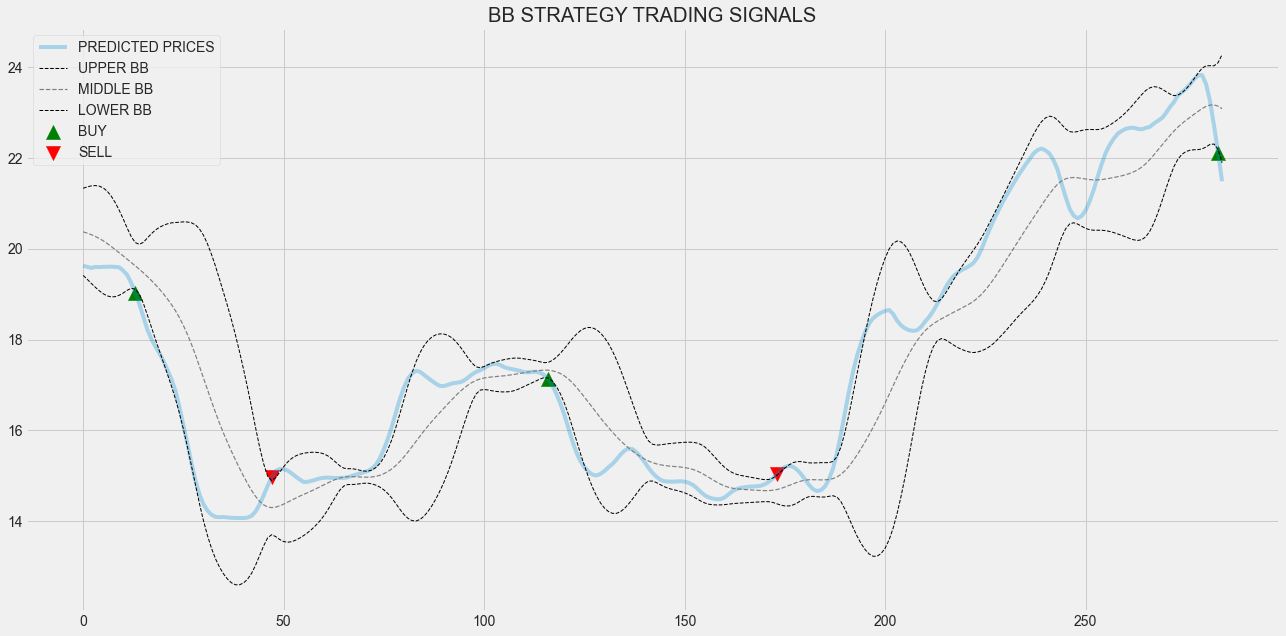

The actual returns had a value of -0.57% and the predicted returns had a value 9.62%


In [10]:
k_pred_prices = scaler_inverse(train_array = k_train['y'].values, predictions = k_predictions)
k_actuals = k_stock_features['y'].values


k_bollinger_df = get_bollinger_df(k_actuals, k_pred_prices, 20 )

# M Stock

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 300)            362400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 300)            721200    
_________________________________________________________________
lstm_8 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 4s 146ms/step - loss: 0.1833 - val_loss: 0.0034

Epoch 00001: val_loss did not improve from 0.00186
Epoch 2/100
7/7 [==============================] - 0s 46ms/step - loss: 0.0553 - val_loss: 

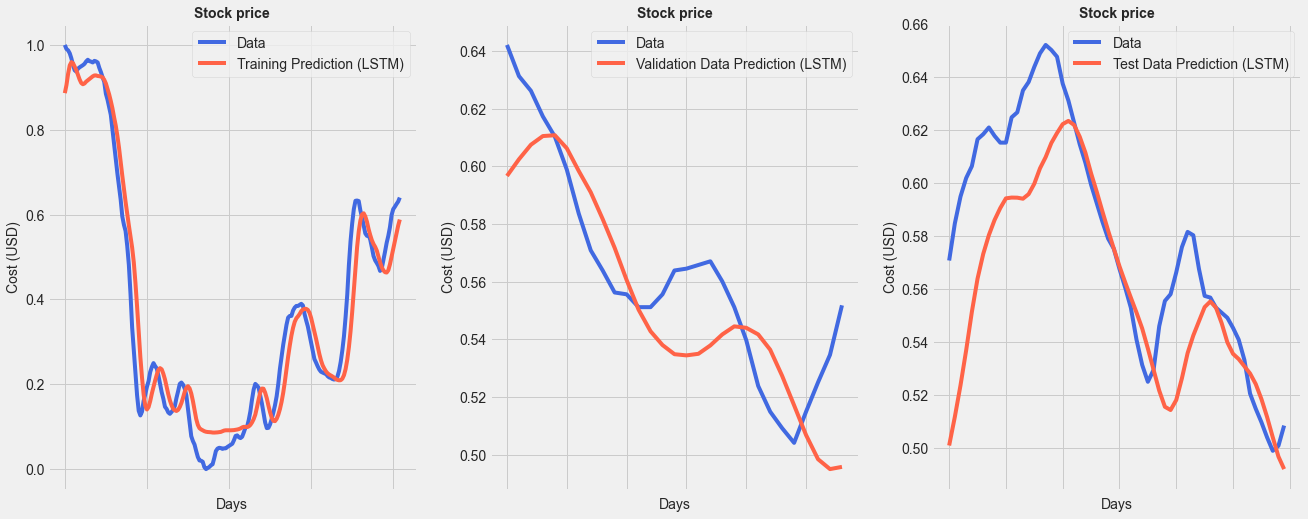

In [11]:
m_stock = read_data("data.xlsx", 2)

m_stock_features = Lookback_data(m_stock, 5)

m_train, m_val, m_test = split_dataset(m_stock_features)

m_train_scaled, m_val_scaled, m_test_scaled = scaling(m_train, m_val, m_test)

X_train, y_train, X_val, y_val, X_test, y_test = seperate_feature_target(m_train_scaled, m_val_scaled, m_test_scaled)

model = NN_model(300,300,300)

m_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

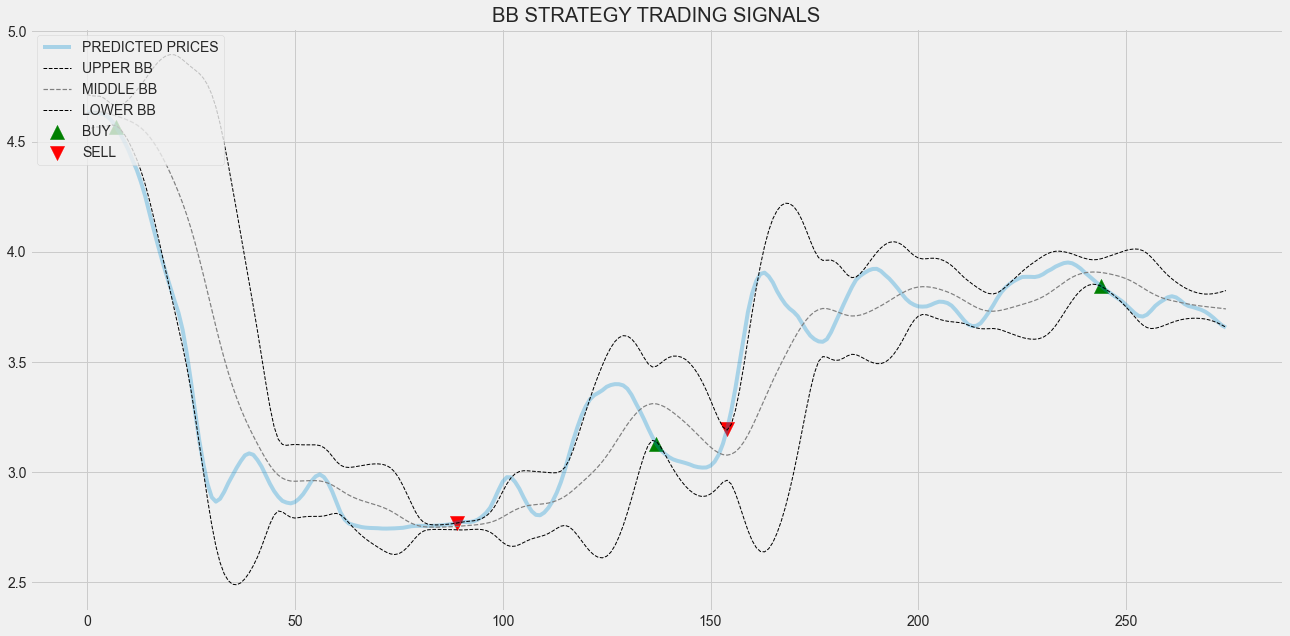

The actual returns had a value of -21.5% and the predicted returns had a value -21.08%


In [12]:
m_pred_prices = scaler_inverse(train_array = m_train['y'].values, predictions = m_predictions)
m_actuals = m_stock_features['y'].values


m_bollinger_df = get_bollinger_df(m_actuals, m_pred_prices, 20 )

## BEEF

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 5, 300)            362400    
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 300)            721200    
_________________________________________________________________
lstm_11 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 4s 147ms/step - loss: 0.3564 - val_loss: 0.0668

Epoch 00001: val_loss did not improve from 0.00048
Epoch 2/100
7/7 [==============================] - 0s 48ms/step - loss: 0.0697 - val_loss: 

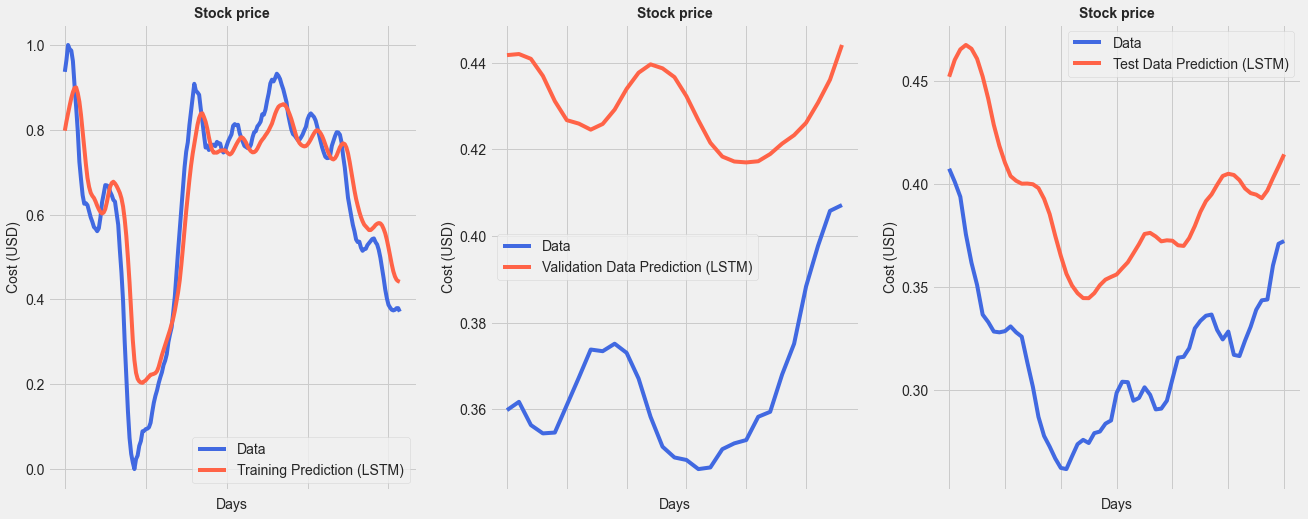

In [13]:
b_stock = read_data("data.xlsx", 3)

b_stock_features = Lookback_data(b_stock, 5)

b_train, b_val, b_test = split_dataset(b_stock_features)

b_train_scaled, b_val_scaled, b_test_scaled = scaling(b_train, b_val, b_test)

X_train, y_train, X_val, y_val, X_test, y_test = seperate_feature_target(b_train_scaled, b_val_scaled, b_test_scaled)

model = NN_model(300,300,300)

b_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

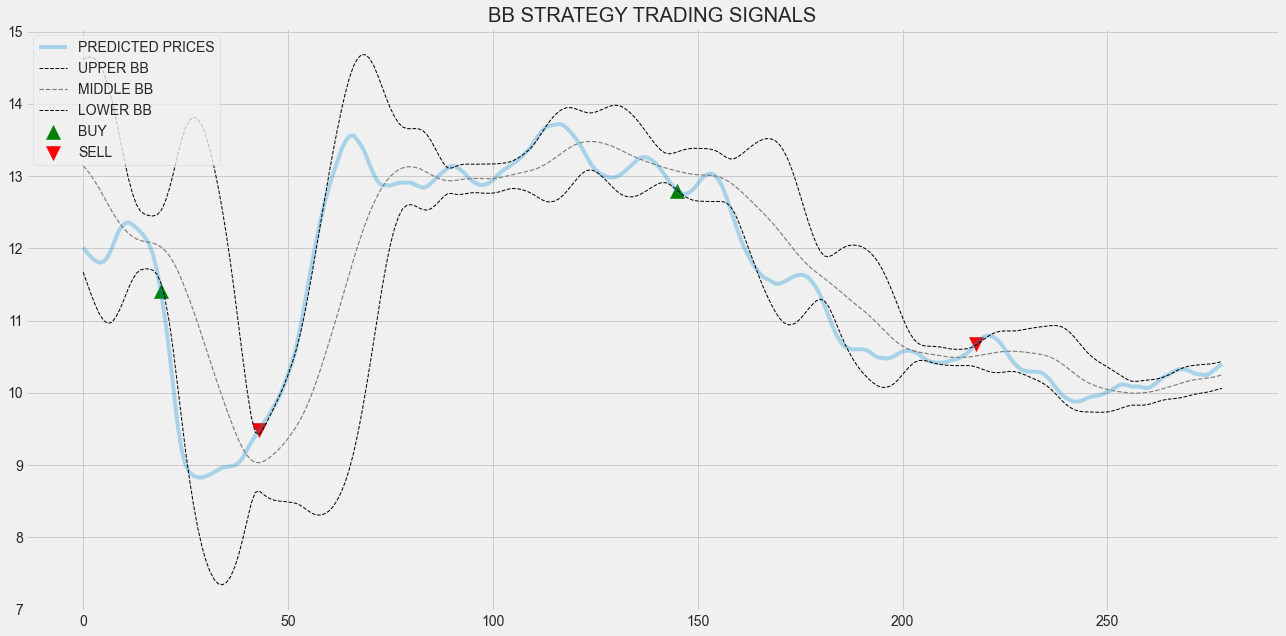

The actual returns had a value of -12.22% and the predicted returns had a value -12.9%


In [14]:
b_pred_prices = scaler_inverse(train_array = b_train['y'].values, predictions = b_predictions)
b_actuals = b_stock_features['y'].values


b_bollinger_df = get_bollinger_df(b_actuals, b_pred_prices, 20 )

## P_stock

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 5, 300)            362400    
_________________________________________________________________
lstm_13 (LSTM)               (None, 5, 300)            721200    
_________________________________________________________________
lstm_14 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 4s 151ms/step - loss: 0.1438 - val_loss: 0.0190

Epoch 00001: val_loss did not improve from 0.00029
Epoch 2/100
7/7 [==============================] - 0s 46ms/step - loss: 0.0516 - val_loss: 

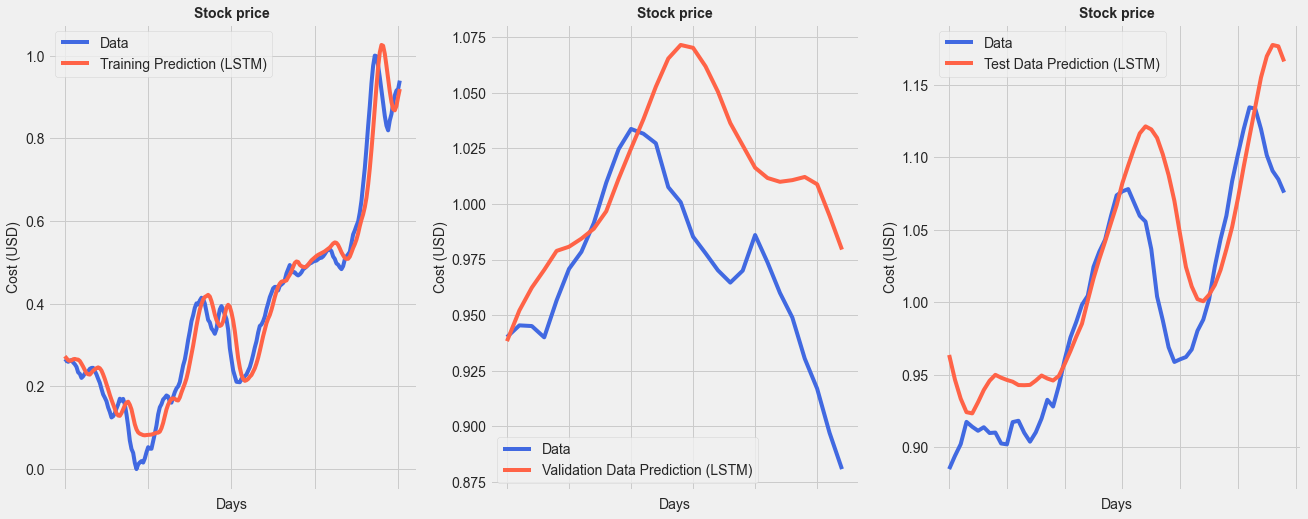

In [15]:
p_stock = read_data("data.xlsx", 4)

p_stock_features = Lookback_data(p_stock, 5)

p_train, p_val, p_test = split_dataset(p_stock_features)

p_train_scaled, p_val_scaled, p_test_scaled = scaling(p_train, p_val, p_test)

X_train, y_train, X_val, y_val, X_test, y_test = seperate_feature_target(p_train_scaled, p_val_scaled, p_test_scaled)

model = NN_model(300,300,300)

p_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

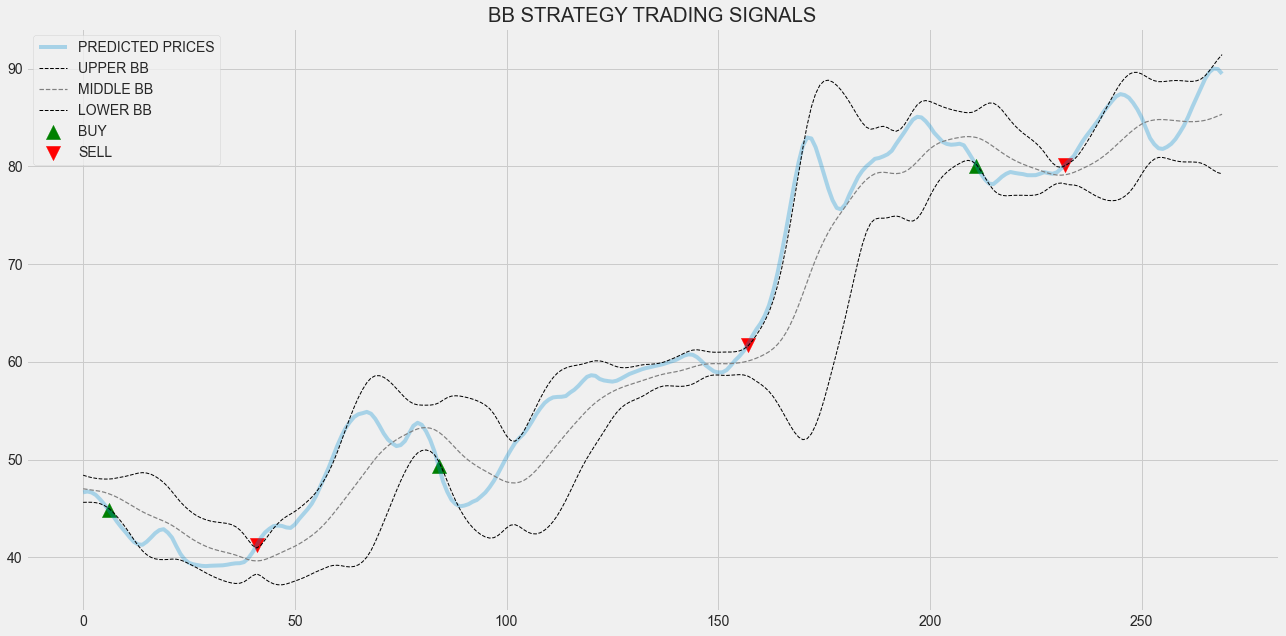

The actual returns had a value of 87.65% and the predicted returns had a value 91.49%


In [16]:
p_pred_prices = scaler_inverse(train_array = p_train['y'].values, predictions = p_predictions)
p_actuals = p_stock_features['y'].values


p_bollinger_df = get_bollinger_df(p_actuals, p_pred_prices, 20 )

## C Stock

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5, 300)            362400    
_________________________________________________________________
lstm_16 (LSTM)               (None, 5, 300)            721200    
_________________________________________________________________
lstm_17 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 4s 150ms/step - loss: 0.1744 - val_loss: 0.0099

Epoch 00001: val_loss did not improve from 0.00029
Epoch 2/100
7/7 [==============================] - 0s 48ms/step - loss: 0.0513 - val_loss: 

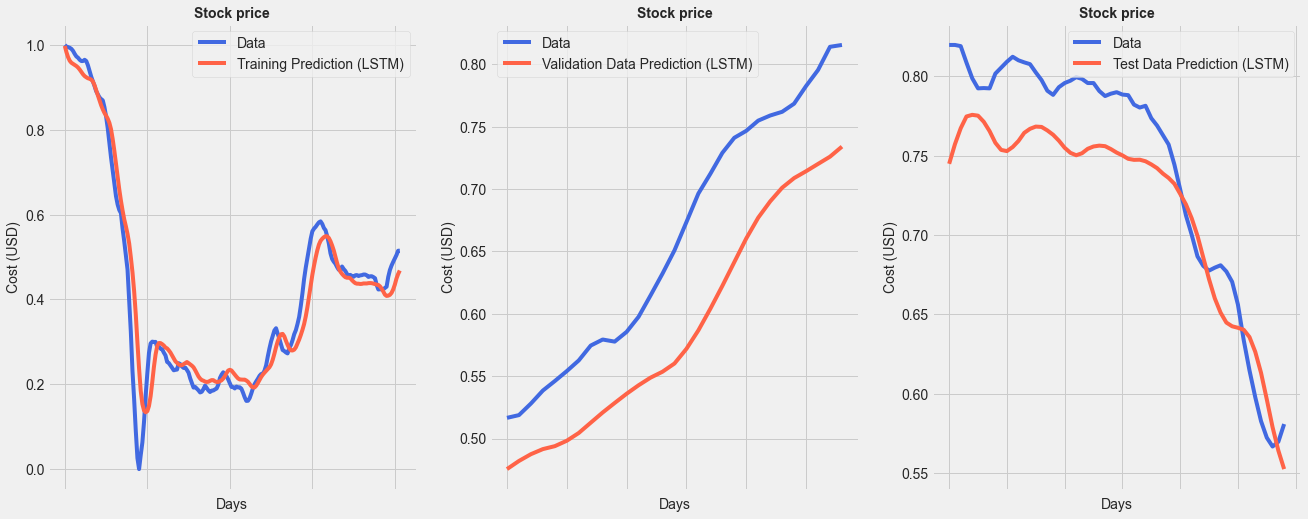

In [17]:
c_stock = read_data("data.xlsx", 5)

c_stock_features = Lookback_data(c_stock, 5)

c_train, c_val, c_test = split_dataset(c_stock_features)

c_train_scaled, c_val_scaled, c_test_scaled = scaling(c_train, c_val, c_test)

X_train, y_train, X_val, y_val, X_test, y_test = seperate_feature_target(c_train_scaled, c_val_scaled, c_test_scaled)

model = NN_model(300,300,300)

c_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

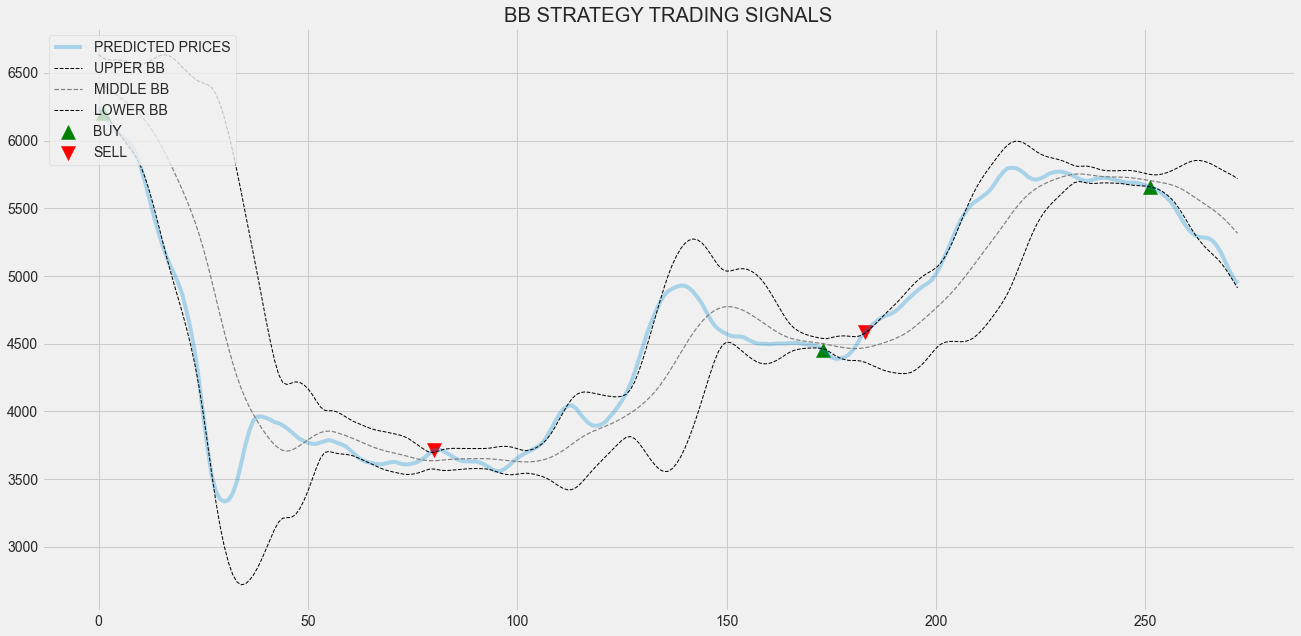

The actual returns had a value of -18.72% and the predicted returns had a value -20.3%


In [18]:
c_pred_prices = scaler_inverse(train_array = c_train['y'].values, predictions = c_predictions)
c_actuals = c_stock_features['y'].values


c_bollinger_df = get_bollinger_df(c_actuals, c_pred_prices, 20 )

## I stock

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 5, 300)            362400    
_________________________________________________________________
lstm_19 (LSTM)               (None, 5, 300)            721200    
_________________________________________________________________
lstm_20 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 4s 151ms/step - loss: 0.4143 - val_loss: 0.0281

Epoch 00001: val_loss did not improve from 0.00029
Epoch 2/100
7/7 [==============================] - 0s 48ms/step - loss: 0.0666 - val_loss: 

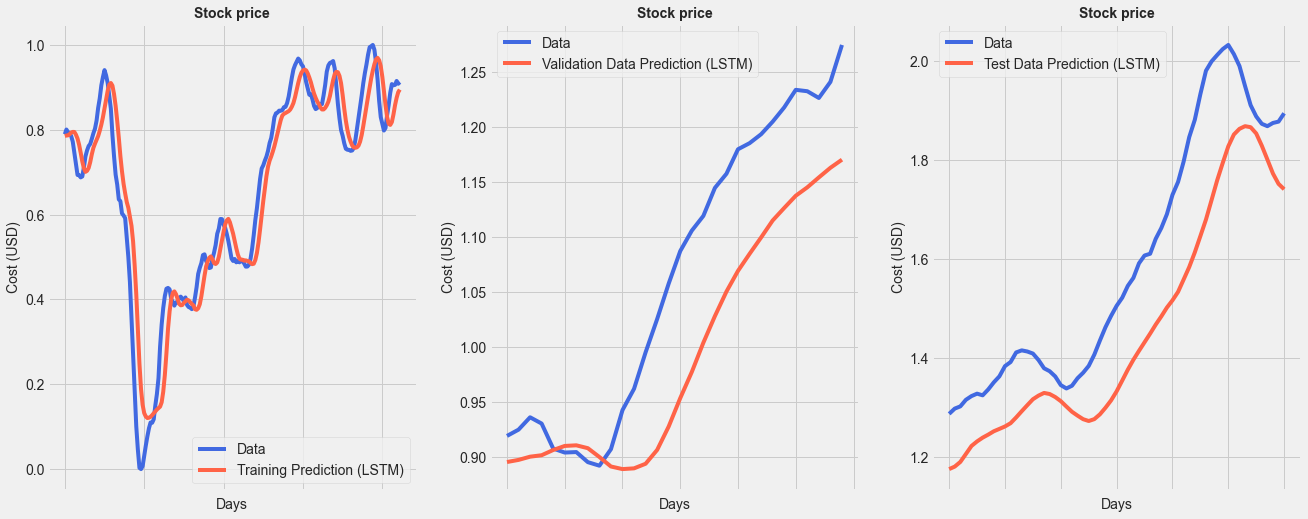

In [19]:
i_stock = read_data("data.xlsx", 6)

i_stock_features = Lookback_data(i_stock, 5)

i_train, i_val, i_test = split_dataset(i_stock_features)

i_train_scaled, i_val_scaled, i_test_scaled = scaling(i_train, i_val, i_test)

X_train, y_train, X_val, y_val, X_test, y_test = seperate_feature_target(i_train_scaled, i_val_scaled, i_test_scaled)

model = NN_model(300,300,300)

i_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

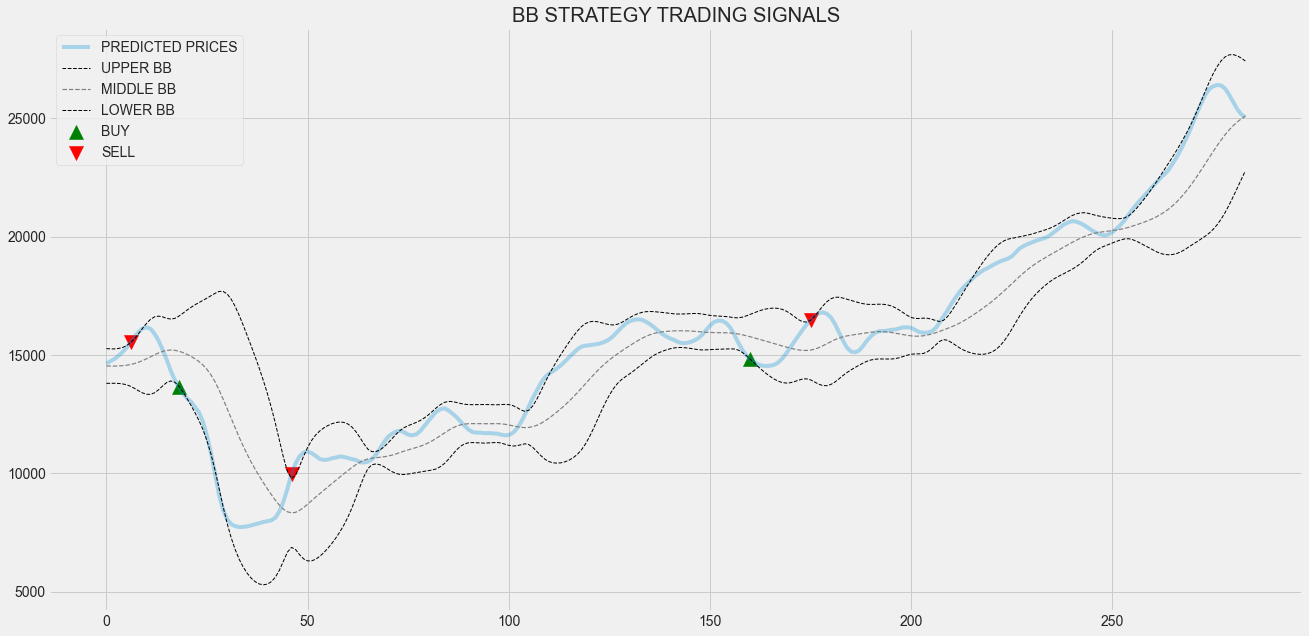

The actual returns had a value of 75.29% and the predicted returns had a value 69.98%


In [20]:
i_pred_prices = scaler_inverse(train_array = i_train['y'].values, predictions = i_predictions)
i_actuals = i_stock_features['y'].values


i_bollinger_df = get_bollinger_df(i_actuals, i_pred_prices, 20 )

# D Stock

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 5, 300)            362400    
_________________________________________________________________
lstm_22 (LSTM)               (None, 5, 300)            721200    
_________________________________________________________________
lstm_23 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 301       
Total params: 1,805,101
Trainable params: 1,805,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 5s 136ms/step - loss: 0.3175 - val_loss: 0.0108

Epoch 00001: val_loss did not improve from 0.00029
Epoch 2/100
8/8 [==============================] - 0s 45ms/step - loss: 0.0727 - val_loss: 

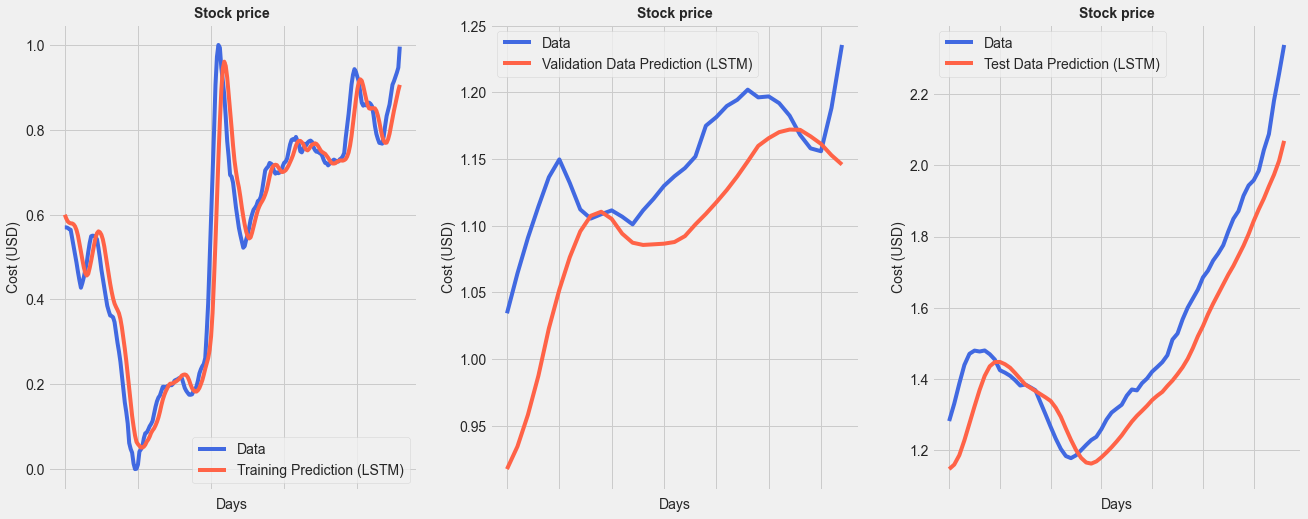

In [21]:
d_stock = read_data("data.xlsx", 7)

d_stock_features = Lookback_data(d_stock, 5)

d_train, d_val, d_test = split_dataset(d_stock_features)

d_train_scaled, d_val_scaled, d_test_scaled = scaling(d_train, d_val, d_test)

X_train, y_train, X_val, y_val, X_test, y_test = seperate_feature_target(d_train_scaled, d_val_scaled, d_test_scaled)

model = NN_model(300,300,300)

d_predictions = run_NN(model, X_train, y_train, X_val, y_val, X_test, y_test, callbacks)

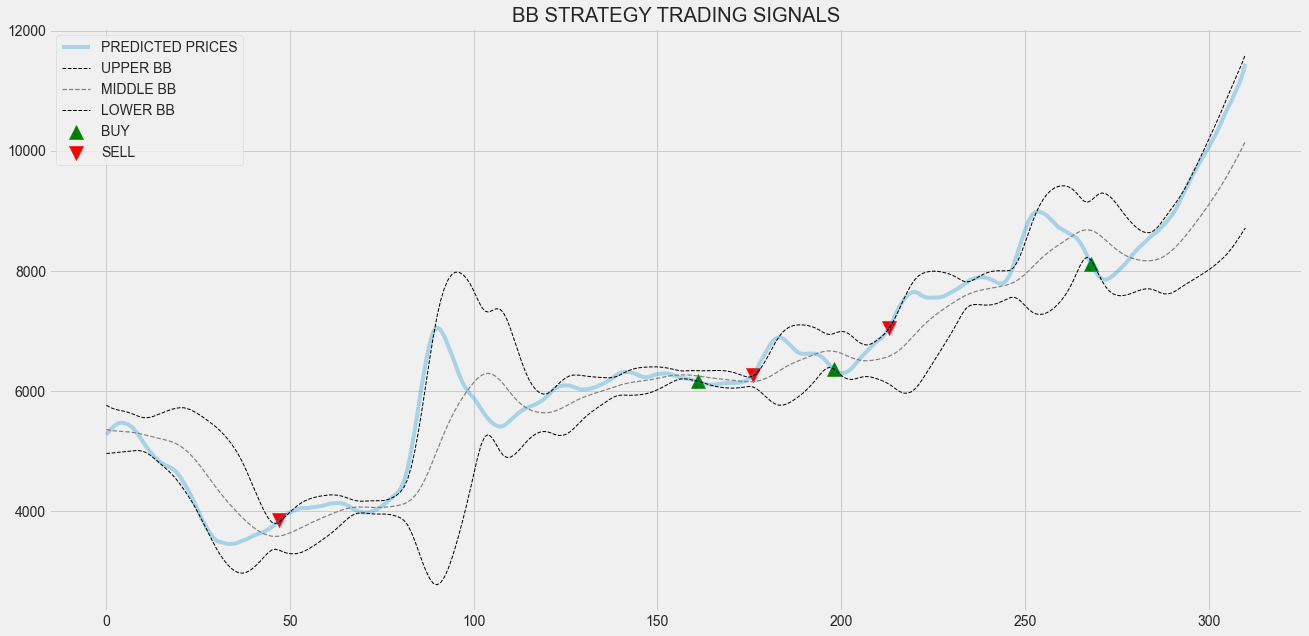

The actual returns had a value of 130.41% and the predicted returns had a value 114.07%


In [22]:
d_pred_prices = scaler_inverse(train_array = d_train['y'].values, predictions = d_predictions)
d_actuals = d_stock_features['y'].values


d_bollinger_df = get_bollinger_df(d_actuals, d_pred_prices, 20 )

# Model Reinforcement

In [23]:
class model_reinforcement:
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
        
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [24]:
def plot_signals(values):
    fig = plt.figure(figsize = (15,5))
    plt.plot(values, color='r', lw=2.)
    plt.plot(values, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
    plt.plot(values, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
    plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
    plt.legend()
    plt.show()

In [25]:

initial_money = 1000
window_size = 5
skip = 1
batch_size = 32

# S Stock Reinforcement model

In [32]:
# Define the values for the S Stock

close = s_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 62.234286.3, cost: 0.034478, total money: 1062.234286
epoch: 20, total rewards: 76.432857.3, cost: 0.031815, total money: 1076.432857
epoch: 30, total rewards: 63.222857.3, cost: 0.031112, total money: 1063.222857
epoch: 40, total rewards: 57.870000.3, cost: 0.020998, total money: 1057.870000
epoch: 50, total rewards: 60.554286.3, cost: 0.019215, total money: 1060.554286
epoch: 60, total rewards: 51.671429.3, cost: 0.018791, total money: 1051.671429
epoch: 70, total rewards: 26.855714.3, cost: 0.019305, total money: 1026.855714
epoch: 80, total rewards: 29.431429.3, cost: 0.018875, total money: 1029.431429
epoch: 90, total rewards: 27.032857.3, cost: 0.019164, total money: 1027.032857
epoch: 100, total rewards: 22.000000.3, cost: 0.018662, total money: 1022.000000


In [33]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 262.321429, total balance 737.678571
day 2, sell 1 unit at price 262.990000, investment 0.254867 %, total balance 1000.668571,
day 73: buy 1 unit at price 194.127143, total balance 806.541429
day 74, sell 1 unit at price 195.071429, investment 0.486426 %, total balance 1001.612857,
day 91: buy 1 unit at price 200.667143, total balance 800.945714
day 92, sell 1 unit at price 205.024286, investment 2.171328 %, total balance 1005.970000,
day 114: buy 1 unit at price 209.382857, total balance 796.587143
day 115, sell 1 unit at price 209.855714, investment 0.225834 %, total balance 1006.442857,
day 116: buy 1 unit at price 211.150000, total balance 795.292857
day 117, sell 1 unit at price 210.977143, investment -0.081865 %, total balance 1006.270000,
day 122: buy 1 unit at price 211.044286, total balance 795.225714
day 123, sell 1 unit at price 211.537143, investment 0.233533 %, total balance 1006.762857,
day 124: buy 1 unit at price 212.725714, total balance 794.

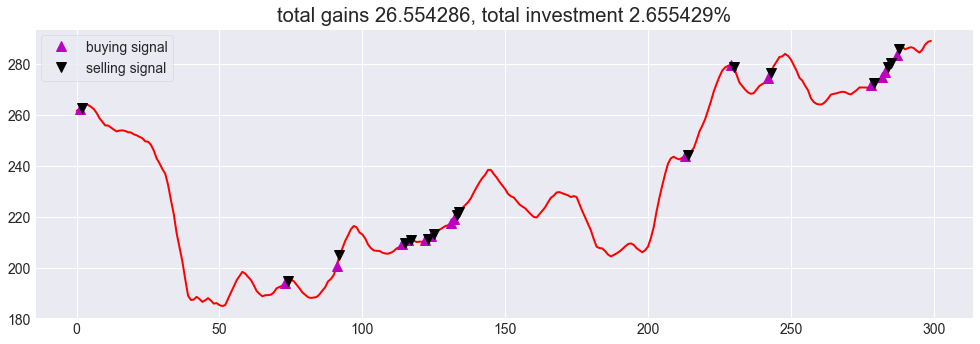

In [36]:
plot_signals(values = s_actuals)

In [55]:
# Define the values for the S Stock

close = s_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: -355.638031.3, cost: 0.107623, total money: 644.361969
epoch: 20, total rewards: -366.092224.3, cost: 0.093460, total money: 633.907776
epoch: 30, total rewards: -370.992569.3, cost: 0.081500, total money: 629.007431
epoch: 40, total rewards: -368.919098.3, cost: 0.069080, total money: 631.080902
epoch: 50, total rewards: -380.642960.3, cost: 0.063525, total money: 619.357040
epoch: 60, total rewards: -378.848129.3, cost: 0.065884, total money: 621.151871
epoch: 70, total rewards: -370.754837.3, cost: 0.073696, total money: 629.245163
epoch: 80, total rewards: -331.746750.3, cost: 0.058589, total money: 668.253250
epoch: 90, total rewards: -267.731461.3, cost: 0.043322, total money: 732.268539
epoch: 100, total rewards: -254.268143.3, cost: 0.035449, total money: 745.731857


In [56]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 258.186401, total balance 741.813599
day 3, sell 1 unit at price 259.134277, investment 0.367129 %, total balance 1000.947876,
day 8: buy 1 unit at price 261.942352, total balance 739.005524
day 10: buy 1 unit at price 259.496979, total balance 479.508545
day 11: buy 1 unit at price 257.879944, total balance 221.628601
day 12, sell 1 unit at price 256.265442, investment -2.167237 %, total balance 477.894043,
day 13, sell 1 unit at price 254.877045, investment -1.780342 %, total balance 732.771088,
day 21: buy 1 unit at price 251.166901, total balance 481.604187
day 23: buy 1 unit at price 250.304153, total balance 231.300034
day 24, sell 1 unit at price 249.846252, investment -3.115284 %, total balance 481.146286,
day 25, sell 1 unit at price 249.180054, investment -0.791046 %, total balance 730.326340,
day 28, sell 1 unit at price 246.912567, investment -1.354986 %, total balance 977.238907,
day 29: buy 1 unit at price 245.516220, total balance 731.722687
da

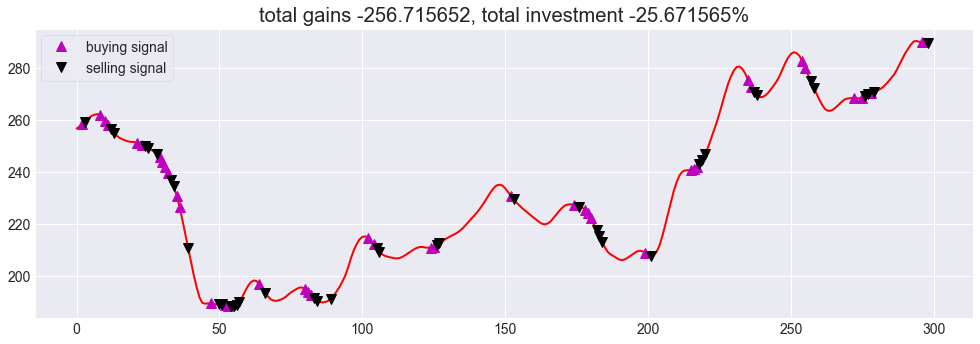

In [57]:
plot_signals(values = s_pred_prices.reshape(-1))

# K Stock Reinforcement model

In [58]:
# Define the values for the S Stock

close = k_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: -14.120000.3, cost: 0.327766, total money: 22.011429
epoch: 20, total rewards: 16.967143.3, cost: 0.227976, total money: 158.171429
epoch: 30, total rewards: 55.374286.3, cost: 0.133166, total money: 397.750000
epoch: 40, total rewards: 62.458571.3, cost: 0.088160, total money: 523.648571
epoch: 50, total rewards: 84.641429.3, cost: 0.044628, total money: 679.842857
epoch: 60, total rewards: 94.827143.3, cost: 0.013823, total money: 856.747143
epoch: 70, total rewards: 62.012857.3, cost: 0.002989, total money: 969.901429
epoch: 80, total rewards: 70.311429.3, cost: 0.002151, total money: 1000.802857
epoch: 90, total rewards: 54.187143.3, cost: 0.001334, total money: 1054.187143
epoch: 100, total rewards: 67.678571.3, cost: 0.001566, total money: 1021.138571


In [59]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 20.908571, total balance 979.091429
day 3: buy 1 unit at price 21.071429, total balance 958.020000
day 4: buy 1 unit at price 21.088571, total balance 936.931429
day 5, sell 1 unit at price 21.088571, investment 0.860891 %, total balance 958.020000,
day 6, sell 1 unit at price 21.028571, investment -0.203390 %, total balance 979.048571,
day 7, sell 1 unit at price 20.871429, investment -1.029671 %, total balance 999.920000,
day 11: buy 1 unit at price 20.072857, total balance 979.847143
day 12: buy 1 unit at price 19.907143, total balance 959.940000
day 13: buy 1 unit at price 19.882857, total balance 940.057143
day 14: buy 1 unit at price 19.880000, total balance 920.177143
day 15: buy 1 unit at price 19.880000, total balance 900.297143
day 16: buy 1 unit at price 19.764286, total balance 880.532857
day 17: buy 1 unit at price 19.825714, total balance 860.707143
day 18, sell 1 unit at price 19.810000, investment -1.309515 %, total balance 880.517143,
day 19:

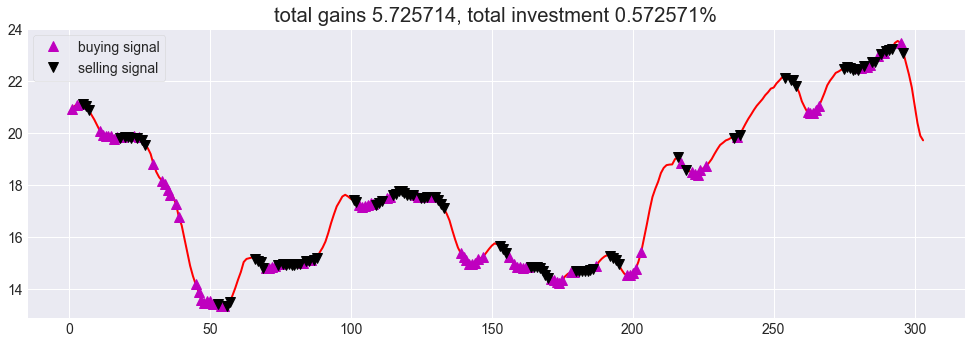

In [60]:
plot_signals(values = k_actuals)

In [61]:
# Define the values for the S Stock

close = k_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 0.411730.3, cost: 0.000032, total money: 1000.411730
epoch: 20, total rewards: 0.007641.3, cost: 0.000032, total money: 1000.007641
epoch: 30, total rewards: -0.325198.3, cost: 0.000300, total money: 999.674802
epoch: 40, total rewards: -1.177058.3, cost: 0.000298, total money: 998.822942
epoch: 50, total rewards: -1.696621.3, cost: 0.000283, total money: 998.303379
epoch: 60, total rewards: -1.836871.3, cost: 0.000297, total money: 998.163129
epoch: 70, total rewards: -2.899860.3, cost: 0.000287, total money: 997.100140
epoch: 80, total rewards: -4.840413.3, cost: 0.000329, total money: 995.159587
epoch: 90, total rewards: -6.003059.3, cost: 0.000335, total money: 993.996941
epoch: 100, total rewards: -8.900276.3, cost: 0.000382, total money: 991.099724


In [62]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 20.150532, total balance 979.849468
day 1, sell 1 unit at price 20.249180, investment 0.489556 %, total balance 1000.098648,
day 24: buy 1 unit at price 19.605186, total balance 980.493462
day 25: buy 1 unit at price 19.605465, total balance 960.887997
day 27: buy 1 unit at price 19.601927, total balance 941.286070
day 28: buy 1 unit at price 19.595142, total balance 921.690928
day 30: buy 1 unit at price 19.423120, total balance 902.267807
day 33, sell 1 unit at price 18.788321, investment -4.166581 %, total balance 921.056128,
day 35, sell 1 unit at price 18.222801, investment -7.052440 %, total balance 939.278929,
day 36, sell 1 unit at price 18.014860, investment -8.096483 %, total balance 957.293789,
day 37, sell 1 unit at price 17.849234, investment -8.909906 %, total balance 975.143023,
day 38, sell 1 unit at price 17.699465, investment -8.874247 %, total balance 992.842487,
day 56: buy 1 unit at price 14.069217, total balance 978.773271
day 59: buy 1 

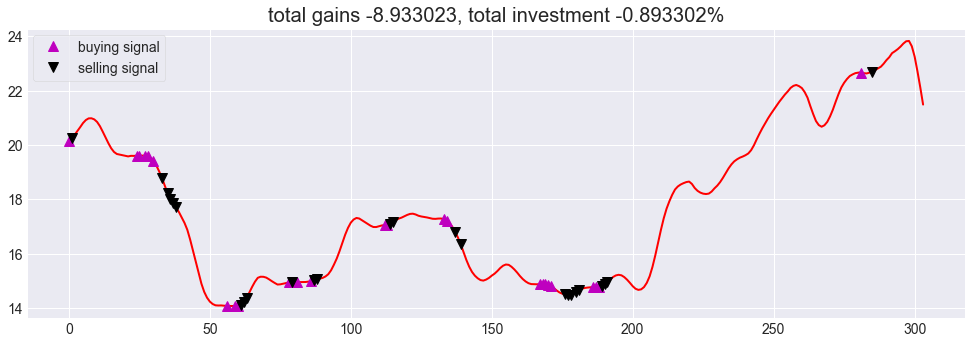

In [63]:
plot_signals(values = k_pred_prices.reshape(-1))

# M Stock Reinforcement model

In [64]:
# Define the values for the S Stock

close = m_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 4.080000.3, cost: 0.015997, total money: 770.244286
epoch: 20, total rewards: 0.904286.3, cost: 0.006019, total money: 863.628571
epoch: 30, total rewards: 0.887143.3, cost: 0.004095, total money: 886.512857
epoch: 40, total rewards: 0.927143.3, cost: 0.003526, total money: 893.637143
epoch: 50, total rewards: 0.547143.3, cost: 0.003172, total money: 900.982857
epoch: 60, total rewards: 0.138571.3, cost: 0.002757, total money: 904.340000
epoch: 70, total rewards: 0.214286.3, cost: 0.001889, total money: 919.432857
epoch: 80, total rewards: -2.728571.3, cost: 0.001171, total money: 943.711429
epoch: 90, total rewards: 2.167143.3, cost: 0.001569, total money: 936.670000
epoch: 100, total rewards: -0.672857.3, cost: 0.001005, total money: 949.724286


In [65]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 5: buy 1 unit at price 4.690000, total balance 995.310000
day 9, sell 1 unit at price 4.678571, investment -0.243680 %, total balance 999.988571,
day 25: buy 1 unit at price 4.538571, total balance 995.450000
day 26: buy 1 unit at price 4.507143, total balance 990.942857
day 28: buy 1 unit at price 4.427143, total balance 986.515714
day 29: buy 1 unit at price 4.348571, total balance 982.167143
day 30: buy 1 unit at price 4.268571, total balance 977.898571
day 31: buy 1 unit at price 4.190000, total balance 973.708571
day 32: buy 1 unit at price 4.117143, total balance 969.591429
day 33: buy 1 unit at price 4.047143, total balance 965.544286
day 34: buy 1 unit at price 3.978571, total balance 961.565714
day 35: buy 1 unit at price 3.888571, total balance 957.677143
day 36: buy 1 unit at price 3.844286, total balance 953.832857
day 37: buy 1 unit at price 3.811429, total balance 950.021429
day 38: buy 1 unit at price 3.732857, total balance 946.288571
day 39: buy 1 unit at price 3.6

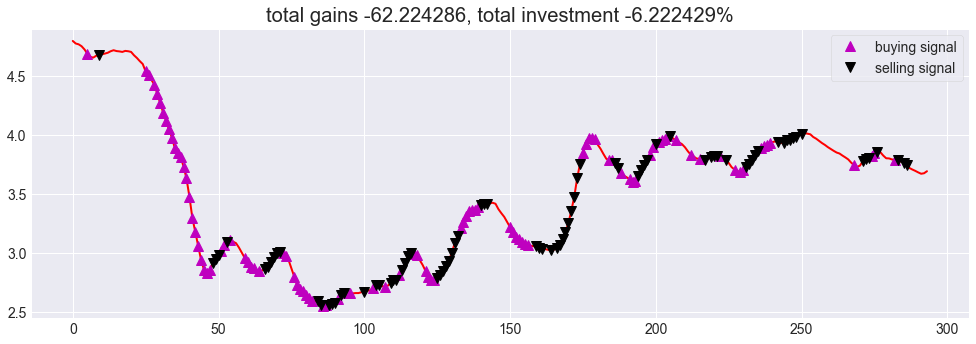

In [66]:
plot_signals(values = m_actuals)

In [67]:
# Define the values for the S Stock

close = m_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: -12.793932.3, cost: 0.023245, total money: 736.975066
epoch: 20, total rewards: -12.632697.3, cost: 0.010981, total money: 819.566369
epoch: 30, total rewards: -14.321251.3, cost: 0.005694, total money: 875.008154
epoch: 40, total rewards: -11.987988.3, cost: 0.004150, total money: 896.534149
epoch: 50, total rewards: -15.167632.3, cost: 0.002551, total money: 927.442555
epoch: 60, total rewards: -16.530809.3, cost: 0.002154, total money: 933.916353
epoch: 70, total rewards: -17.251667.3, cost: 0.002189, total money: 936.976851
epoch: 80, total rewards: -15.131794.3, cost: 0.001735, total money: 946.652416
epoch: 90, total rewards: -18.751083.3, cost: 0.001531, total money: 950.460071
epoch: 100, total rewards: -15.694413.3, cost: 0.001580, total money: 953.717927


In [68]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 4.643813, total balance 995.356187
day 3: buy 1 unit at price 4.689068, total balance 990.667119
day 4: buy 1 unit at price 4.706131, total balance 985.960989
day 5: buy 1 unit at price 4.700260, total balance 981.260728
day 6: buy 1 unit at price 4.681984, total balance 976.578744
day 9: buy 1 unit at price 4.614273, total balance 971.964471
day 12, sell 1 unit at price 4.593205, investment -1.089787 %, total balance 976.557676,
day 13, sell 1 unit at price 4.602879, investment -1.838079 %, total balance 981.160555,
day 14, sell 1 unit at price 4.609708, investment -2.048864 %, total balance 985.770264,
day 15, sell 1 unit at price 4.616876, investment -1.774030 %, total balance 990.387140,
day 16, sell 1 unit at price 4.624202, investment -1.234139 %, total balance 995.011342,
day 17, sell 1 unit at price 4.630805, investment 0.358289 %, total balance 999.642148,
day 27: buy 1 unit at price 4.535065, total balance 995.107083
day 28: buy 1 unit at price 4.49

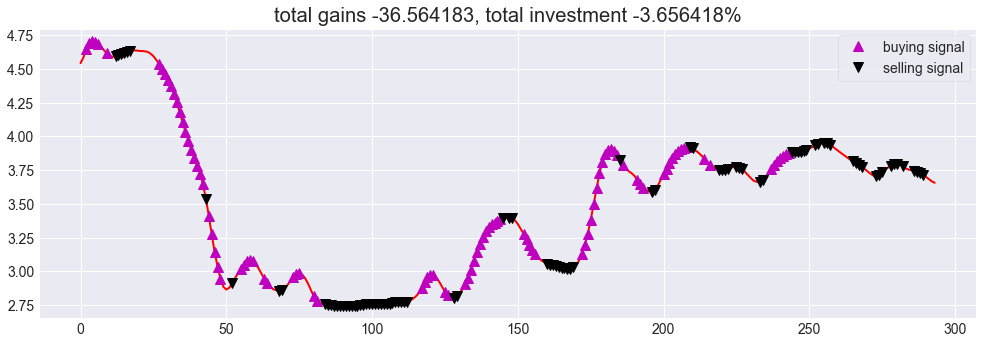

In [69]:
plot_signals(values = m_pred_prices.reshape(-1))

# B Stock Reinforcement model

In [70]:
# Define the values for the S Stock

close = b_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 0.177143.3, cost: 0.000009, total money: 1000.177143
epoch: 20, total rewards: 0.322857.3, cost: 0.000009, total money: 1000.322857
epoch: 30, total rewards: -0.327143.3, cost: 0.000047, total money: 999.672857
epoch: 40, total rewards: -0.164286.3, cost: 0.000047, total money: 999.835714
epoch: 50, total rewards: -0.361429.3, cost: 0.000043, total money: 999.638571
epoch: 60, total rewards: -0.208571.3, cost: 0.000040, total money: 999.791429
epoch: 70, total rewards: -0.305714.3, cost: 0.000038, total money: 999.694286
epoch: 80, total rewards: -0.692857.3, cost: 0.000039, total money: 999.307143
epoch: 90, total rewards: -0.745714.3, cost: 0.000037, total money: 999.254286
epoch: 100, total rewards: -0.745714.3, cost: 0.000035, total money: 999.254286


In [71]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 14.290000, total balance 985.710000
day 2, sell 1 unit at price 14.762857, investment 3.309007 %, total balance 1000.472857,
day 5: buy 1 unit at price 14.478571, total balance 985.994286
day 6, sell 1 unit at price 14.055714, investment -2.920572 %, total balance 1000.050000,
day 28: buy 1 unit at price 12.182857, total balance 987.867143
day 29, sell 1 unit at price 12.122857, investment -0.492495 %, total balance 999.990000,
day 218: buy 1 unit at price 10.090000, total balance 989.900000
day 219, sell 1 unit at price 10.045714, investment -0.438907 %, total balance 999.945714,
day 238: buy 1 unit at price 10.300000, total balance 989.645714
day 239, sell 1 unit at price 10.245714, investment -0.527046 %, total balance 999.891429,
day 250: buy 1 unit at price 9.740000, total balance 990.151429
day 251: buy 1 unit at price 9.647143, total balance 980.504286
day 253, sell 1 unit at price 9.450000, investment -2.977413 %, total balance 989.954286,
day 256, se

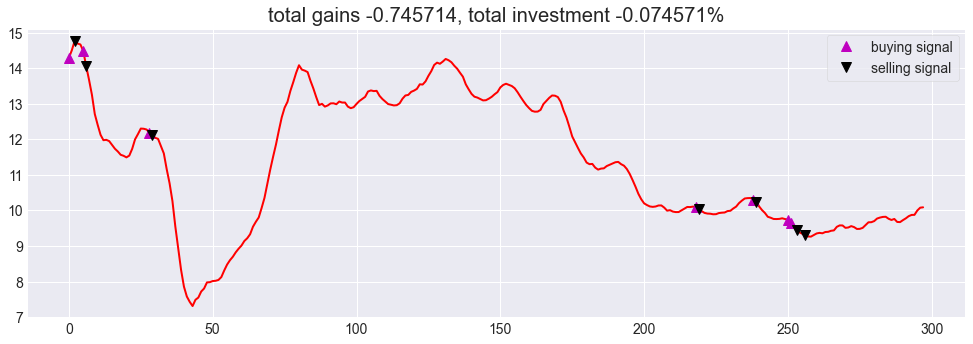

In [72]:
plot_signals(values = b_actuals)

In [73]:
# Define the values for the S Stock

close = b_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 19.581302.3, cost: 0.021823, total money: 782.511984
epoch: 20, total rewards: 17.544817.3, cost: 0.007102, total money: 905.969628
epoch: 30, total rewards: 31.956012.3, cost: 0.002804, total money: 960.616357
epoch: 40, total rewards: 35.398940.3, cost: 0.000749, total money: 1014.831791
epoch: 50, total rewards: 42.169700.3, cost: 0.000273, total money: 1042.169700
epoch: 60, total rewards: 46.165014.3, cost: 0.000178, total money: 1035.851928
epoch: 70, total rewards: 59.183485.3, cost: 0.000475, total money: 1048.870399
epoch: 80, total rewards: 50.546032.3, cost: 0.000317, total money: 1040.232945
epoch: 90, total rewards: 53.471956.3, cost: 0.000472, total money: 1043.158870
epoch: 100, total rewards: 53.548802.3, cost: 0.000474, total money: 1043.235716


In [74]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 1: buy 1 unit at price 13.417948, total balance 986.582052
day 2: buy 1 unit at price 13.560963, total balance 973.021090
day 3: buy 1 unit at price 13.699907, total balance 959.321182
day 4: buy 1 unit at price 13.829370, total balance 945.491812
day 5, sell 1 unit at price 13.934762, investment 3.851664 %, total balance 959.426574,
day 6, sell 1 unit at price 14.005972, investment 3.281546 %, total balance 973.432546,
day 7, sell 1 unit at price 14.016627, investment 2.311841 %, total balance 987.449173,
day 8, sell 1 unit at price 13.916357, investment 0.628999 %, total balance 1001.365530,
day 26: buy 1 unit at price 12.001470, total balance 989.364060
day 27: buy 1 unit at price 12.149387, total balance 977.214673
day 28: buy 1 unit at price 12.273237, total balance 964.941436
day 29: buy 1 unit at price 12.337897, total balance 952.603539
day 30, sell 1 unit at price 12.359076, investment 2.979692 %, total balance 964.962615,
day 31, sell 1 unit at price 12.329475, investment

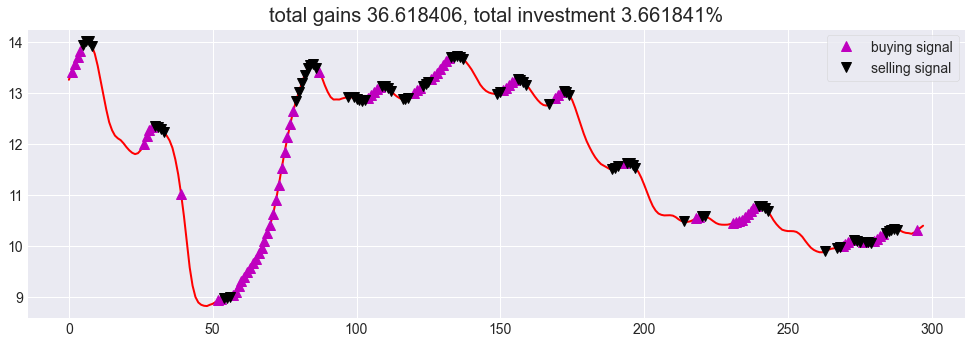

In [75]:
plot_signals(values = b_pred_prices.reshape(-1))

# P Stock Reinforcement model

In [76]:
# Define the values for the S Stock

close = p_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: -76.457143.3, cost: 0.042491, total money: 575.828571
epoch: 20, total rewards: -60.557143.3, cost: 0.037788, total money: 591.728571
epoch: 30, total rewards: -36.407143.3, cost: 0.021423, total money: 615.878571
epoch: 40, total rewards: -52.114286.3, cost: 0.033732, total money: 600.171429
epoch: 50, total rewards: -51.714286.3, cost: 0.032574, total money: 600.571429
epoch: 60, total rewards: -49.364286.3, cost: 0.031082, total money: 602.921429
epoch: 70, total rewards: -48.964286.3, cost: 0.029991, total money: 603.321429
epoch: 80, total rewards: -43.528571.3, cost: 0.029719, total money: 608.757143
epoch: 90, total rewards: -43.300000.3, cost: 0.027395, total money: 608.985714
epoch: 100, total rewards: -48.414286.3, cost: 0.027157, total money: 603.871429


In [77]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 47.350000, total balance 952.650000
day 4: buy 1 unit at price 47.550000, total balance 905.100000
day 7: buy 1 unit at price 46.785714, total balance 858.314286
day 11, sell 1 unit at price 45.735714, investment -3.409262 %, total balance 904.050000,
day 12, sell 1 unit at price 46.035714, investment -3.184618 %, total balance 950.085714,
day 13, sell 1 unit at price 46.185714, investment -1.282443 %, total balance 996.271429,
day 15: buy 1 unit at price 46.564286, total balance 949.707143
day 16: buy 1 unit at price 46.664286, total balance 903.042857
day 18: buy 1 unit at price 46.328571, total balance 856.714286
day 19: buy 1 unit at price 45.935714, total balance 810.778571
day 20: buy 1 unit at price 45.442857, total balance 765.335714
day 25, sell 1 unit at price 42.921429, investment -7.823286 %, total balance 808.257143,
day 29, sell 1 unit at price 41.235714, investment -11.633247 %, total balance 849.492857,
day 30, sell 1 unit at price 41.564286, 

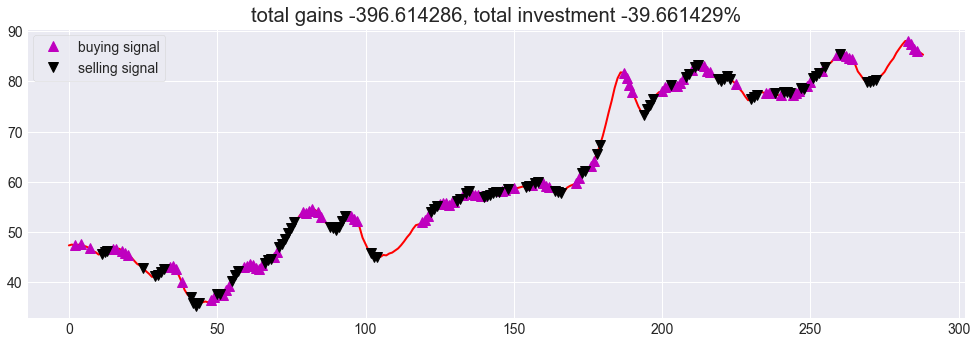

In [78]:
plot_signals(values = p_actuals)

In [79]:
# Define the values for the S Stock

close = p_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 108.142941.3, cost: 0.008135, total money: 1108.142941
epoch: 20, total rewards: 105.420071.3, cost: 0.004734, total money: 1105.420071
epoch: 30, total rewards: 115.930561.3, cost: 0.004618, total money: 1115.930561
epoch: 40, total rewards: 116.852005.3, cost: 0.004583, total money: 1116.852005
epoch: 50, total rewards: 131.177212.3, cost: 0.007071, total money: 1131.177212
epoch: 60, total rewards: 117.956024.3, cost: 0.004508, total money: 1117.956024
epoch: 70, total rewards: 114.661057.3, cost: 0.004415, total money: 1114.661057
epoch: 80, total rewards: 120.137695.3, cost: 0.004461, total money: 1120.137695
epoch: 90, total rewards: 117.750889.3, cost: 0.004373, total money: 1117.750889
epoch: 100, total rewards: 117.365257.3, cost: 0.006173, total money: 1117.365257


In [80]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 47.979645, total balance 952.020355
day 1, sell 1 unit at price 47.761353, investment -0.454968 %, total balance 999.781708,
day 7: buy 1 unit at price 47.621815, total balance 952.159893
day 8: buy 1 unit at price 47.599613, total balance 904.560280
day 9, sell 1 unit at price 47.444714, investment -0.371891 %, total balance 952.004993,
day 10, sell 1 unit at price 47.137032, investment -0.971818 %, total balance 999.142025,
day 22: buy 1 unit at price 46.370850, total balance 952.771175
day 23, sell 1 unit at price 45.928829, investment -0.953229 %, total balance 998.700005,
day 39: buy 1 unit at price 42.526669, total balance 956.173336
day 40: buy 1 unit at price 42.006554, total balance 914.166782
day 41, sell 1 unit at price 41.139194, investment -3.262598 %, total balance 955.305977,
day 42, sell 1 unit at price 40.330784, investment -3.989306 %, total balance 995.636761,
day 53: buy 1 unit at price 39.237392, total balance 956.399368
day 54: buy 1 uni

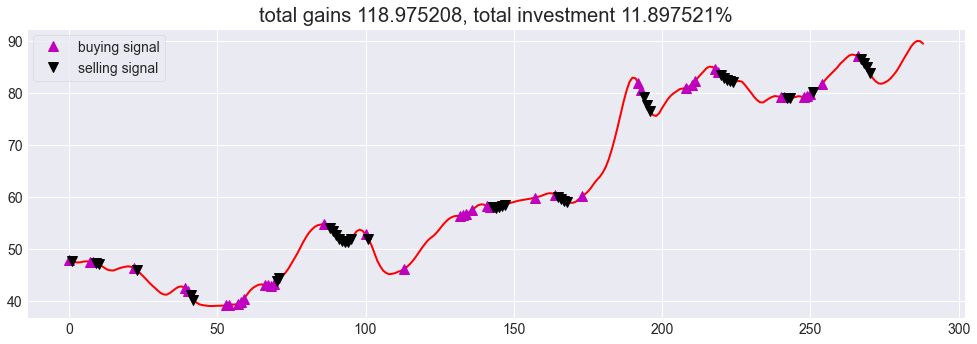

In [81]:
plot_signals(values = p_pred_prices.reshape(-1))

In [94]:
initial_money = 100000

# C Stock Reinforcement model

In [95]:
# Define the values for the S Stock

close = c_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

epoch: 10, total rewards: 1546.000000.3, cost: 0.085101, total money: 90973.571429
epoch: 20, total rewards: 10370.142857.3, cost: 0.080650, total money: 64429.142857
epoch: 30, total rewards: 10024.000000.3, cost: 0.039494, total money: 104233.285714
epoch: 40, total rewards: 6657.714286.3, cost: 0.024237, total money: 90023.857143
epoch: 50, total rewards: 7851.571429.3, cost: 0.062516, total money: 102735.571429
epoch: 60, total rewards: 10575.857143.3, cost: 0.020852, total money: 71328.142857
epoch: 70, total rewards: 6304.000000.3, cost: 0.020252, total money: 67056.285714
epoch: 80, total rewards: -3108.857143.3, cost: 0.019209, total money: 96891.142857
epoch: 90, total rewards: 3806.571429.3, cost: 0.015169, total money: 76364.571429
epoch: 100, total rewards: 3362.428571.3, cost: 0.100286, total money: 93188.285714


In [96]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 6660.000000, total balance 93340.000000
day 1, sell 1 unit at price 6644.285714, investment -0.235950 %, total balance 99984.285714,
day 9: buy 1 unit at price 6525.714286, total balance 93458.571429
day 12, sell 1 unit at price 6525.714286, investment 0.000000 %, total balance 99984.285714,
day 13: buy 1 unit at price 6514.285714, total balance 93470.000000
day 14, sell 1 unit at price 6475.714286, investment -0.592105 %, total balance 99945.714286,
day 37: buy 1 unit at price 4758.571429, total balance 95187.142857
day 38, sell 1 unit at price 4627.142857, investment -2.761933 %, total balance 99814.285714,
day 52: buy 1 unit at price 3958.571429, total balance 95855.714286
day 53: buy 1 unit at price 3974.285714, total balance 91881.428571
day 57: buy 1 unit at price 3930.000000, total balance 87951.428571
day 63: buy 1 unit at price 3780.714286, total balance 84170.714286
day 67, sell 1 unit at price 3719.285714, investment -6.044749 %, total balance 8789

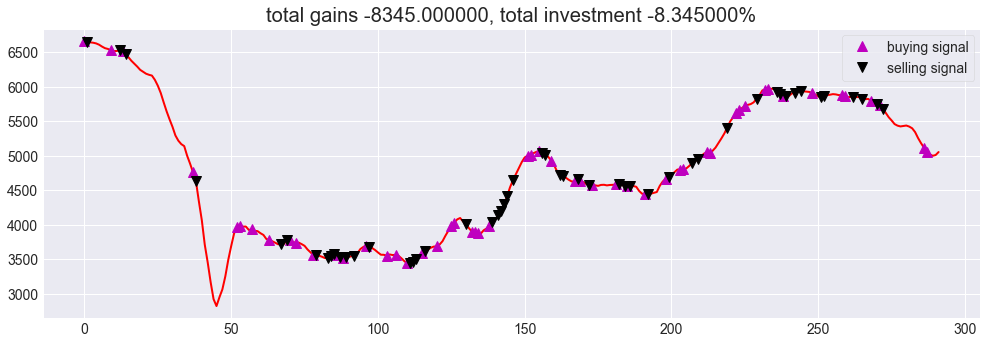

In [97]:
plot_signals(values = c_actuals)

In [98]:
# Define the values for the S Stock

close = c_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 1376.988037.3, cost: 0.020260, total money: 80545.972900
epoch: 20, total rewards: 869.950928.3, cost: 0.013211, total money: 90324.603760
epoch: 30, total rewards: 1633.204102.3, cost: 0.013577, total money: 91087.856934
epoch: 40, total rewards: 704.748535.3, cost: 0.011700, total money: 100704.748535
epoch: 50, total rewards: 1412.832520.3, cost: 0.010459, total money: 101412.832520
epoch: 60, total rewards: 425.615723.3, cost: 0.010415, total money: 100425.615723
epoch: 70, total rewards: 598.083740.3, cost: 0.008135, total money: 100598.083740
epoch: 80, total rewards: 449.385498.3, cost: 0.008042, total money: 100449.385498
epoch: 90, total rewards: 841.026123.3, cost: 0.014134, total money: 85329.559814
epoch: 100, total rewards: 590.476807.3, cost: 0.007535, total money: 95415.450439


In [99]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 6516.461426, total balance 93483.538574
day 5: buy 1 unit at price 6488.368164, total balance 86995.170410
day 6: buy 1 unit at price 6478.173828, total balance 80516.996582
day 7: buy 1 unit at price 6469.060059, total balance 74047.936523
day 8, sell 1 unit at price 6455.513672, investment -0.935289 %, total balance 80503.450195,
day 10, sell 1 unit at price 6416.036133, investment -1.114795 %, total balance 86919.486328,
day 11, sell 1 unit at price 6394.811035, investment -1.286826 %, total balance 93314.297363,
day 12, sell 1 unit at price 6378.265625, investment -1.403518 %, total balance 99692.562988,
day 15: buy 1 unit at price 6353.566895, total balance 93338.996094
day 16: buy 1 unit at price 6346.582031, total balance 86992.414062
day 17, sell 1 unit at price 6329.782227, investment -0.374351 %, total balance 93322.196289,
day 21, sell 1 unit at price 6155.534180, investment -3.010248 %, total balance 99477.730469,
day 49: buy 1 unit at price 3335.

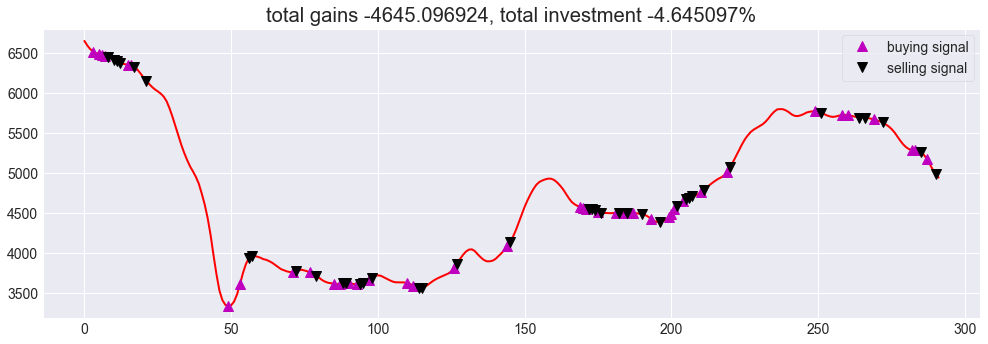

In [100]:
plot_signals(values = c_pred_prices.reshape(-1))

# I Stock Reinforcement model

In [101]:
# Define the values for the S Stock

close = i_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 0.000000.3, cost: nan, total money: 72834.857143
epoch: 20, total rewards: 6553.285714.3, cost: nan, total money: 85021.142857
epoch: 30, total rewards: -143.285714.3, cost: nan, total money: 99856.714286
epoch: 40, total rewards: 0.000000.3, cost: nan, total money: 85339.714286
epoch: 50, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 60, total rewards: 0.000000.3, cost: nan, total money: 100000.000000
epoch: 70, total rewards: 16130.714286.3, cost: nan, total money: 81289.571429
epoch: 80, total rewards: 0.000000.3, cost: nan, total money: 82600.428571
epoch: 90, total rewards: 0.000000.3, cost: nan, total money: 86205.571429
epoch: 100, total rewards: 0.000000.3, cost: nan, total money: 100000.000000


In [102]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 94: buy 1 unit at price 11901.000000, total balance 88099.000000
day 161, sell 1 unit at price 15637.142857, investment 31.393520 %, total balance 103736.142857,
day 251: buy 1 unit at price 21016.857143, total balance 82719.285714


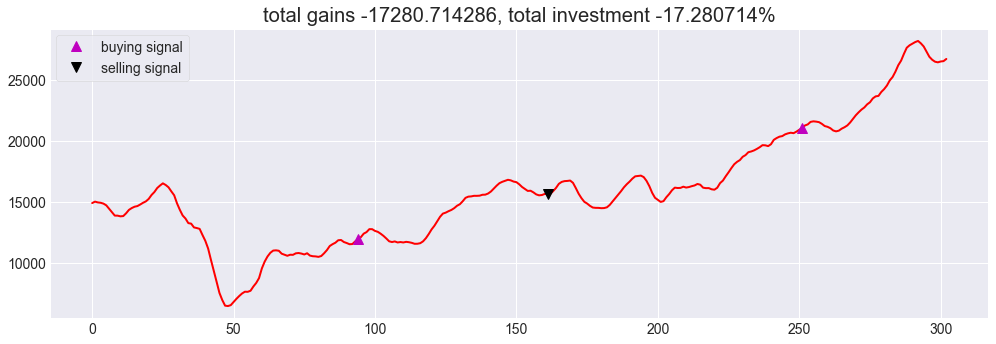

In [103]:
plot_signals(values = i_actuals)

In [104]:
# Define the values for the S Stock

close = i_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 11747.649902.3, cost: 0.233008, total money: 111747.649902
epoch: 20, total rewards: 6563.228516.3, cost: 0.133284, total money: 106563.228516
epoch: 30, total rewards: -7595.443359.3, cost: 0.052990, total money: 92404.556641
epoch: 40, total rewards: 1245.097656.3, cost: 0.024743, total money: 101245.097656
epoch: 50, total rewards: -11442.088867.3, cost: 0.019739, total money: 88557.911133
epoch: 60, total rewards: -1632.800293.3, cost: 0.014626, total money: 98367.199707
epoch: 70, total rewards: -1203.933105.3, cost: 0.015000, total money: 98796.066895
epoch: 80, total rewards: -1733.822266.3, cost: 0.039343, total money: 98266.177734
epoch: 90, total rewards: -2348.154297.3, cost: 0.010554, total money: 97651.845703
epoch: 100, total rewards: 16504.913086.3, cost: 0.047972, total money: 116504.913086


In [105]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 9: buy 1 unit at price 14616.653320, total balance 85383.346680
day 18, sell 1 unit at price 14538.769531, investment -0.532843 %, total balance 99922.116211,
day 33: buy 1 unit at price 15217.112305, total balance 84705.003906
day 37, sell 1 unit at price 13633.979492, investment -10.403635 %, total balance 98338.983398,
day 43: buy 1 unit at price 12180.420898, total balance 86158.562500
day 45: buy 1 unit at price 10852.291016, total balance 75306.271484
day 49, sell 1 unit at price 8066.713867, investment -33.773111 %, total balance 83372.985352,
day 51: buy 1 unit at price 7770.578125, total balance 75602.407227
day 52: buy 1 unit at price 7732.100098, total balance 67870.307129
day 53: buy 1 unit at price 7740.211426, total balance 60130.095703
day 54: buy 1 unit at price 7762.295410, total balance 52367.800293
day 57, sell 1 unit at price 7899.726074, investment -27.206835 %, total balance 60267.526367,
day 59, sell 1 unit at price 7982.193848, investment 2.723294 %, total b

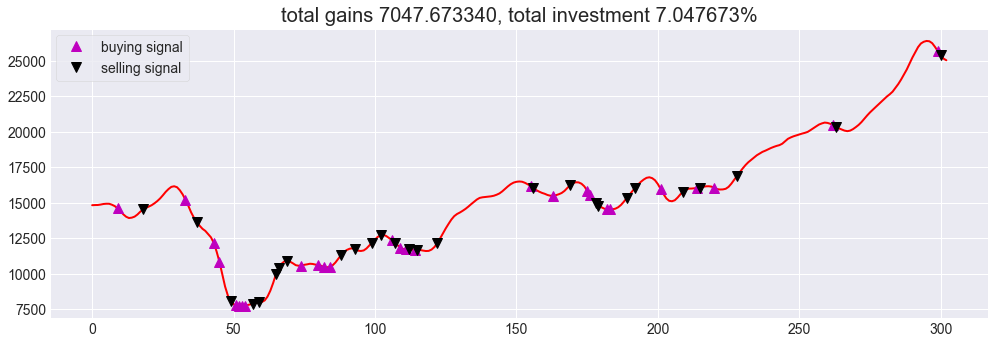

In [106]:
plot_signals(values = i_pred_prices.reshape(-1))

# D Stock Reinforcement model

In [107]:
# Define the values for the S Stock

close = d_actuals.tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: -3332.857143.3, cost: 0.159478, total money: 96667.142857
epoch: 20, total rewards: -3445.000000.3, cost: 0.046186, total money: 96555.000000
epoch: 30, total rewards: -6272.142857.3, cost: 0.026952, total money: 93727.857143
epoch: 40, total rewards: -1851.428571.3, cost: 0.017749, total money: 98148.571429
epoch: 50, total rewards: -3142.142857.3, cost: 0.326249, total money: 96857.857143
epoch: 60, total rewards: -5262.142857.3, cost: 0.012796, total money: 94737.857143
epoch: 70, total rewards: -3012.857143.3, cost: 0.008591, total money: 96987.142857
epoch: 80, total rewards: -3016.428571.3, cost: 0.008320, total money: 96983.571429
epoch: 90, total rewards: -3827.142857.3, cost: 0.006184, total money: 96172.857143
epoch: 100, total rewards: -5505.000000.3, cost: 0.006517, total money: 94495.000000


In [108]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 5495.714286, total balance 94504.285714
day 4, sell 1 unit at price 5488.571429, investment -0.129971 %, total balance 99992.857143,
day 6: buy 1 unit at price 5341.428571, total balance 94651.428571
day 7, sell 1 unit at price 5262.142857, investment -1.484354 %, total balance 99913.571429,
day 11: buy 1 unit at price 4947.857143, total balance 94965.714286
day 12, sell 1 unit at price 4992.142857, investment 0.895048 %, total balance 99957.857143,
day 27: buy 1 unit at price 4945.000000, total balance 95012.857143
day 29: buy 1 unit at price 4780.000000, total balance 90232.857143
day 30: buy 1 unit at price 4731.428571, total balance 85501.428571
day 31: buy 1 unit at price 4688.571429, total balance 80812.857143
day 33, sell 1 unit at price 4672.142857, investment -5.517839 %, total balance 85485.000000,
day 34: buy 1 unit at price 4626.428571, total balance 80858.571429
day 35: buy 1 unit at price 4532.142857, total balance 76326.428571
day 40: buy 1 uni

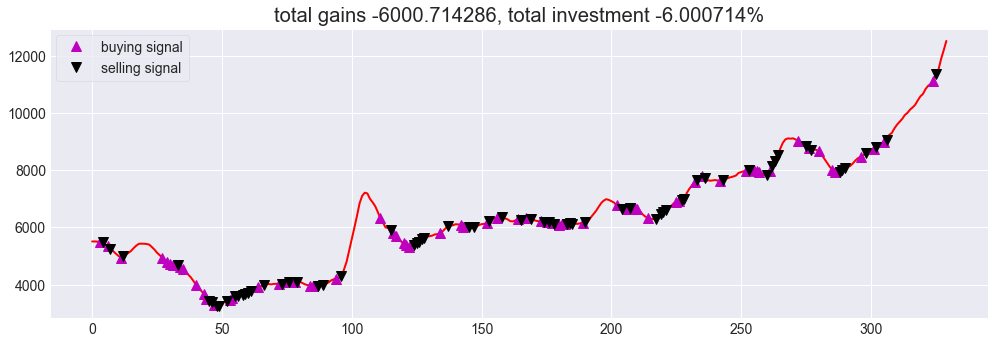

In [109]:
plot_signals(values = d_actuals)

In [110]:
# Define the values for the S Stock

close = d_pred_prices.reshape(-1).tolist()

agent = model_reinforcement(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)

# Use the train function
agent.train(iterations = 100, checkpoint = 10, initial_money = initial_money)

C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\JUGAL\anaconda3\envs\APZIVA\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 41403.325439.3, cost: 0.095748, total money: 141403.325439
epoch: 20, total rewards: 23887.583496.3, cost: 0.060954, total money: 123887.583496
epoch: 30, total rewards: 15007.668457.3, cost: 0.053921, total money: 115007.668457
epoch: 40, total rewards: 5403.383057.3, cost: 0.056055, total money: 105403.383057
epoch: 50, total rewards: 4068.943359.3, cost: 0.045816, total money: 104068.943359
epoch: 60, total rewards: 3552.131348.3, cost: 0.085429, total money: 103552.131348
epoch: 70, total rewards: 3272.536377.3, cost: 0.034481, total money: 103272.536377
epoch: 80, total rewards: 1369.557129.3, cost: 0.023521, total money: 101369.557129
epoch: 90, total rewards: 4253.275635.3, cost: 0.023765, total money: 104253.275635
epoch: 100, total rewards: -758.653320.3, cost: 0.019161, total money: 99241.346680


In [111]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 5629.577148, total balance 94370.422852
day 2: buy 1 unit at price 5567.066895, total balance 88803.355957
day 4, sell 1 unit at price 5548.668945, investment -1.437199 %, total balance 94352.024902,
day 6, sell 1 unit at price 5539.812012, investment -0.489573 %, total balance 99891.836914,
day 11: buy 1 unit at price 5286.471680, total balance 94605.365234
day 13: buy 1 unit at price 5137.708984, total balance 89467.656250
day 15: buy 1 unit at price 5061.847168, total balance 84405.809082
day 16: buy 1 unit at price 5077.018555, total balance 79328.790527
day 18, sell 1 unit at price 5198.946289, investment -1.655649 %, total balance 84527.736816,
day 20, sell 1 unit at price 5347.071777, investment 4.075022 %, total balance 89874.808594,
day 22, sell 1 unit at price 5457.162598, investment 7.809707 %, total balance 95331.971191,
day 23, sell 1 unit at price 5474.081055, investment 7.820781 %, total balance 100806.052246,
day 29: buy 1 unit at price 5153.4

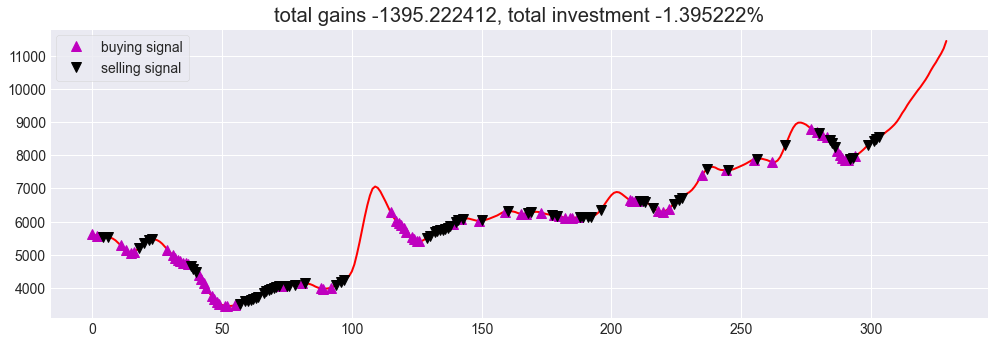

In [112]:
plot_signals(values = d_pred_prices.reshape(-1))